### **Connecting the Google Colab with My Google Drive**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**Importing all the Essential Libraries**

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


**Loading Dataset For Training**

In [4]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Data/data.csv')
df = pd.DataFrame(data)

**Distribution of User Queries over its intent in the dataset**

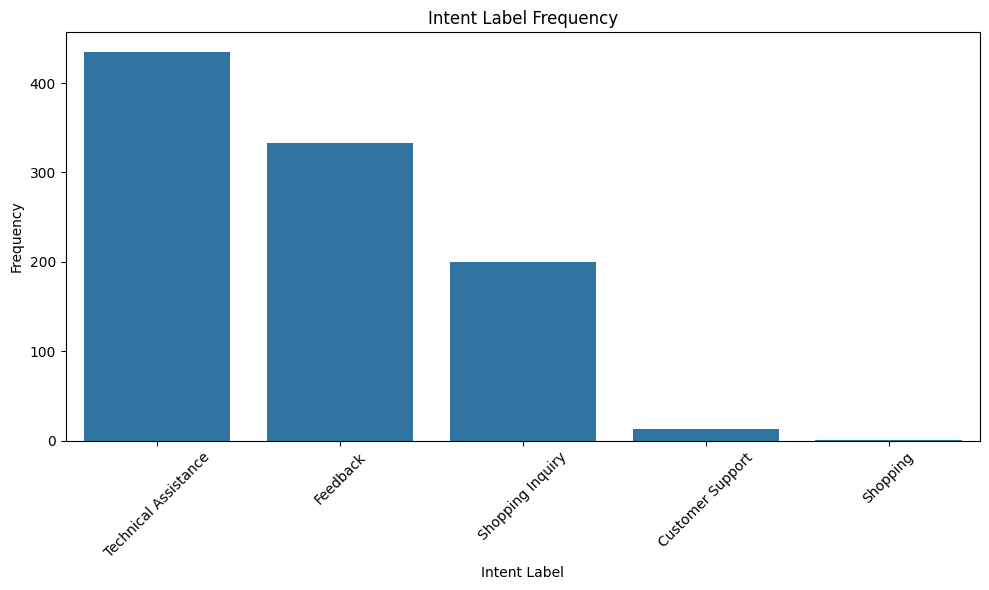

In [5]:
# Count the frequency of each intent
intent_counts = data['intent'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values)
plt.title('Intent Label Frequency')
plt.xlabel('Intent Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Using Bag Of Word Representation for Each word in the text**

In [6]:
# Bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text']).toarray()
y = df['intent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Genetic Algorithm for Feature Selection**

In [7]:
# Genetic Algorithm for feature selection
class GeneticAlgorithm:
    def __init__(self, num_generations=20, population_size=50, mutation_rate=0.1):
        self.num_generations = num_generations
        self.population_size = population_size
        self.mutation_rate = mutation_rate

    def fit(self, X_train, y_train):
        num_features = X_train.shape[1]
        self.best_features = None
        self.best_accuracy = 0

        # Initialize population randomly
        population = np.random.randint(0, 2, size=(self.population_size, num_features))

        for generation in range(self.num_generations):
            # Evaluate fitness of each individual
            fitness_scores = []
            for individual in population:
                features_selected = X_train[:, individual == 1]
                clf = MultinomialNB()
                clf.fit(features_selected, y_train)
                accuracy = clf.score(features_selected, y_train)
                fitness_scores.append(accuracy)


            # Select top individuals for mating
            top_indices = np.argsort(fitness_scores)[::-1][:int(self.population_size/2)]
            top_population = population[top_indices]


            # Perform crossover and mutation
            new_population = []
            for _ in range(self.population_size):
                parents_indices = np.random.choice(top_population.shape[0], size=2, replace=False)
                parent1, parent2 = top_population[parents_indices]
                crossover_point = np.random.randint(0, num_features)
                child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                mutation_mask = np.random.rand(num_features) < self.mutation_rate
                child[mutation_mask] = 1 - child[mutation_mask]  # Flip bits for mutation
                new_population.append(child)

            population = np.array(new_population)


            # Update best features if applicable
            best_individual = population[np.argmax(fitness_scores)]
            best_features_selected = X_train[:, best_individual == 1]
            clf = MultinomialNB()
            clf.fit(best_features_selected, y_train)
            accuracy = clf.score(best_features_selected, y_train)
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_features = best_individual

        return self

    def transform(self, X):
        return X[:, self.best_features == 1]

In [8]:
# Fit genetic algorithm to select features
ga = GeneticAlgorithm()
ga.fit(X_train, y_train)

# Transform training and testing data with selected features
X_train_selected = ga.transform(X_train)
X_test_selected = ga.transform(X_test)

In [9]:
# Train classifier
clf = MultinomialNB()
clf.fit(X_train_selected, y_train)

MultinomialNB()

In [10]:
# Predict and evaluate
y_pred = clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8781725888324873


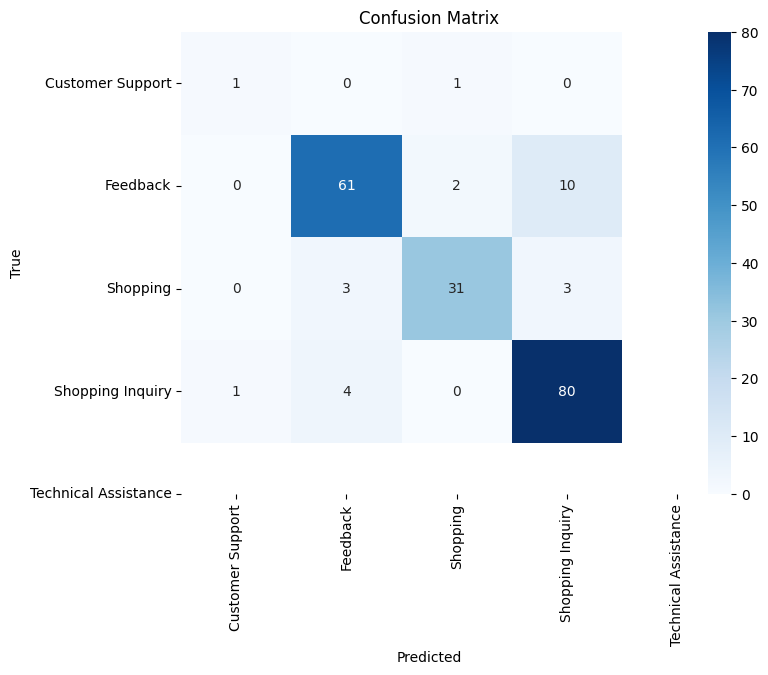

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                      precision    recall  f1-score   support

    Customer Support       0.50      0.50      0.50         2
            Feedback       0.90      0.84      0.87        73
    Shopping Inquiry       0.91      0.84      0.87        37
Technical Assistance       0.86      0.94      0.90        85

            accuracy                           0.88       197
           macro avg       0.79      0.78      0.78       197
        weighted avg       0.88      0.88      0.88       197



In [22]:
# User input for custom text
custom_text = input("Enter your text: ")
custom_text_vectorized = vectorizer.transform([custom_text]).toarray()
custom_text_selected = ga.transform(custom_text_vectorized)
predicted_intent = clf.predict(custom_text_selected)[0]
print("Predicted intent:", predicted_intent)

Enter your text: ye product kaisa hai?
Predicted intent: Feedback
